<a id="section_ID_0"></a>
# Graph-Theoretical Prediction and Analysis of Biological Modules in a Closed Conformation of Mammalian Respiratory complex I - PDB ID 7ZDH

This Jupyter Notebook is part of the supporting information of  <i>Gisdon et al. - Graph-Theoretical Prediction and Analysis of Biologically Relevant Substructures in an Open and Closed Conformation of Respiratory Complex I.</i>
The quaternary structure of the protein complex is modeled as undirected, labeled graph with the vertices representing protein chains and the edges spatial chain-chain contacts. Biological modules are predicted based on the protein graph by partitioning with the Leiden algorithm.

<b>Author:</b><br>
Florian J. Gisdon (mail: florian.gisdon@bioinformatik.uni-frankfurt.de)<br>

The notebook is based on the Jupyter notebooks of <i>Gisdon et al. (2024), Graph-theoretical prediction of biological modules in quaternary structures of large protein complexes. Bioinformatics, 40, btae112, https://doi.org/10.1093/bioinformatics/btae112<i><br>
(The original notebooks were written by Florian J. Gisdon and Kai Prüfer.)

## Table of Contents:

1. **[Requirements](#section_ID_1)**

1. **[Imports](#section_ID_2)**

1. **[Prepare Data and Run PTGLgraphComputation (Optional)](#section_ID_3)**
    <br>3.1 [Check for Installed Software](#section_ID_3.1)
    <br>3.2 [Prepare Variables, Files, and Folders](#section_ID_3.2)
    <br>3.3 [Define Options for the PTGL](#section_ID_3.3)
    <br>3.4 [Compute the Complex Graph with the PTGL](#section_ID_3.4)

1. **[Module Prediction (iGraph) and Analysis](#section_ID_4)**
    <br>4.1 [Import the Complex Graph](#section_ID_4.1)
    <br>4.2 [Perform Community Detection by Optimization of Q-Modularity](#section_ID_4.2)
        <br>4.2.1 [Set Parameters](#section_ID_4.2.1)
        <br>4.2.2 [Perform the Community Detection](#section_ID_4.2.2)
    <br>4.3 [Store/Load Partitions for Later Use](#section_ID_4.3)

1. **[Visualization](#section_ID_5)**
    <br>5.1 [Edge Weight Type](#section_ID_5.1)
        <br>5.1.1 [Choose the Weight Type for the Analysis](#section_ID_5.1.1)
        <br>5.1.2 [Apply a Heatmap Coloring to the Edges According to the Edge Weight](#section_ID_5.1.2)
    <br>5.2 [PyMOL Visualization](#section_ID_5.2)
    <br>5.3 [Prepare Layout According to the Pseudoatom Coordinates](#section_ID_5.3)
    <br>5.4 [Prepare a General Representation Style for the Graphs](#section_ID_5.4)
        <br>5.4.1 [Prepare a Dictionary for Vertex Names for Complex I](#section_ID_5.4.1)
        <br>5.4.2 [Optional Modification of Vertex Positions](#section_ID_5.4.2)
        <br>5.4.3 [Prepare a General Graph Layout Style](#section_ID_5.4.3)
    <br>5.5 [Graph Visualization with Focus on the Network](#section_ID_5.5)
        <br>5.5.1 [Layout Style with Focus on Network](#section_ID_5.5.1)
        <br>5.5.2 [Plotting the Graph](#section_ID_5.5.2)
    <br>5.6 [Graph Visualization with Focus on the Computed Partitions](#section_ID_5.6)
        <br>5.6.1 [Layout Style with Labels and Partitions](#section_ID_5.6.1)
        <br>5.6.2 [Plotting the Graph](#section_ID_5.6.2)

1. **[Graph Analysis Metrics](#section_ID_6)**
    <br>6.1 [Community Comparison](#section_ID_6.1)
        <br>6.1.1 [Calculated Memberships and Reference Memberships](#section_ID_6.1.1)
        <br>6.1.2 [Rand Index](#section_ID_6.1.2)
        <br>6.1.3 [Adjusted Rand Index](#section_ID_6.1.3)
    <br>6.3 [Strength](#section_ID_6.2)
    <br>6.3 [Eigenvector Centrality](#section_ID_6.3)
    <br>6.4 [Betweenness Centrality](#section_ID_6.4)

<a id="section_ID_1"></a>
## 1. Requirements

- igraph
- pycairo
- numpy
- matplotlib
- shutil
- pickle
- pandas
- provided scripts (generalFunctions, pymolRepresentationClustering)

#### Optional

- Protein Topology Graph Library (PTGL)  
    &#10140; PTGLtools - <a href="https://github.com/MolbiFFM/PTGLtools"> GitHub repository</a>
- DSSP  
    &#10140; e.g. DSSP (PDB-REDO) - <a href="https://github.com/PDB-REDO/dssp"> Github repository</a>
- PyMOL

<a id="section_ID_2"></a>
## 2. Imports

In [1]:
import os
import sys
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import warnings

import igraph as ig

# Replace with the absolute path to the directory of the provided scripts ('../../../' in the example).
script_path: str = '../../../'
sys.path.append(script_path)

from pymolRepresentationClustering import prepareClusteringRepresentationPyMOL
from generalFunctions import download_pdb, createLayout, modifyLayoutPosition

<a id="section_ID_3"></a>
## 3. Prepare Data and Run PTGLgraphComputation (Optional)

<div class="alert alert-block alert-info"><b>This example notebook is provided with the required files for all steps and will also run if DSSP, PTGL, or PyMOL is not available. PyMOL is not required for the calculations but for displaying the modules in the protein structure.</b><br>Set variables in section 3.1 to <i>False</i> to run the example without installing PTGL, DSSP, and PyMOL. If the software is available, set the respective variables to <i>True</i> and provide the paths.</div>

<a id="section_ID_3.1"></a>
### 3.1 Check for Installed Software

In [2]:
dssp_software: bool = False
# Applied tool: https://github.com/PDB-REDO/dssp, version 4.4.
# Replace >...< with the absolute path to the dssp executable.
dssp: str = '>/absolute/path/to/mkdssp<'

ptgl_software: bool = False
# Replace >...< with the absolute path to the PTGL executable
ptgl: str = 'java -jar >/absolute/path/to/PTGLgraphComputation.jar<'

# For visualization of the results from the paper, set to True.
pymol_software: bool = False
# Replace >...< with the absolute path to the PyMOL executable.
pymol: str = '>/absolute/path/to/pymol<'


<a id="section_ID_3.2"></a>
### 3.2 Prepare Variables, Files, and Folders

In [3]:
pdb_id: str = '7zdh'

# PDB/mmCIF (should be in the folder where PTGL is started).
structure: str = f'{pdb_id}.cif'

# If required, the mmCIF file is downloaded. For large files it may take some time.
if not os.path.exists(structure):
    print(f"{structure} does not exist in the current working directory.\
          \nDownloading...")
    download_pdb(pdb_id)
    print("Download complete.")

# Set output directory for the results (many files) of the PTGL run.
output_directory: str = 'ptgl_output'
try:
    os.makedirs(output_directory, exist_ok=True)
except OSError as error:
    print("Directory can not be created.")

# Adding the DSSP annotation.
if dssp_software:
    os.system(f'{dssp} {structure} annotated_{structure}')

<a id="section_ID_3.3"></a>
### 3.3 Define Options for the PTGL

In [4]:
options: str = f'-d annotated_{structure} \
                 --complex-graphs \
                 --outputdir {output_directory} \
                 --dont-write-images \
                 --cg-threshold 1'

ptgl_output_file: str = 'PTGLrun.log'

<a id="section_ID_3.4"></a>
### 3.4 Compute the Complex Graph with the PTGL

If an annotated mmCIF is provided with option `'-d'` then the input structure (second positional argument, i.e. {pdb_id}) will be ignored but has to be given (can be given as `'None'`).

In [5]:
if ptgl_software:
    os.system(f'{ptgl} {pdb_id} {options} | tee {ptgl_output_file}')

<a id="section_ID_4"></a>
## 4. Module Prediction (iGraph) and Analysis

<a id="section_ID_4.1"></a>
### 4.1 Import the Complex Graph

In [6]:
# Ignores the possible runtime warning resulting from igraph not being
# able to process one of the custom graph attributes given by PTGL.
warnings.filterwarnings('ignore', category=RuntimeWarning)

graph_file: str = f'{output_directory}/7zdh_complex_chains_albelig_CG.gml'
G = ig.Graph.Read_GML(graph_file)
# Prints number of graph vertices and edges, as well as the attributes.
ig.summary(G)

IGRAPH U--- 45 187 -- 
+ attr: creator (g), factorLucidmultiplicativelengthnormalization (g), ignoreLigands (g), minContactsForEdge (g), version (g), chainLength (v), chainType (v), id (v), label (v), molName (v), absoluteWeight (e), additiveLengthNormalization (e), label (e), lucidMultiplicativeLengthNormalization (e), multiplicativeLengthNormalization (e), numCoilCoilContacts (e), numHelixCoilContacts (e), numHelixHelixContacts (e), numHelixStrandContacts (e), numStrandCoilContacts (e), numStrandStrandContacts (e)


<a id="section_ID_4.2"></a>
### 4.2 Perform Community Detection by Optimization of Q-Modularity

<a id="section_ID_4.2.1"></a>
#### 4.2.1 Set Parameters

In [7]:
# We perform independent computations, since the order in which
# the vertices in the implementation are processed is random, 
# which could lead to variations in the results. We choose the
# partition with the highest Q-modularity. Based on initial
# numerical tests, we performed 2000 computations.
number_of_runs: int = 2000

# List of various weight types, which are written out by the PTGL.
# The Code supports the option to add additional weight types, though
# except for 'absoluteWeight', other types are not yet evaluted.
# 'absoluteWeight' describes the absolute number of contacts.
weight_types: list = ['absoluteWeight']

# Set the resolution parameter for the generalized Q-modularity.
resolution: float = 1.0
# Dictionary, which will store all the partitions with the highest
# Q-modularity for each weight type.
partitions: dict = {}

folder_path: str = "./modularization_results"
# Checking whether folder exists or not.
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    os.makedirs(folder_path)
else:
    os.makedirs(folder_path)

<a id="section_ID_4.2.2"></a>
#### 4.2.2 Perform the Community Detection

In [8]:
for weight_type in weight_types:
    print(f'Edge weight type: {weight_type}')
    calc_modularity: list = []
    best_partition = None

    try:
        for run in range(number_of_runs):
            # Calculate the partitioning.
            part_Leiden_calc = G.community_leiden(objective_function='modularity',
                                                  weights=weight_type,
                                                  resolution_parameter=resolution,
                                                  n_iterations=-1)

            if len(calc_modularity) == 0:
                best_partition = part_Leiden_calc
            elif part_Leiden_calc.modularity > max(calc_modularity):
                best_partition = part_Leiden_calc
            calc_modularity.append(part_Leiden_calc.modularity)

        # Print the SVG image for the best Q-modularity to file.
        ig.plot(best_partition, f"{folder_path}/best_modularity_{weight_type}.svg")
        # Print out the PML-file for the representation with PyMOL.
        pml_file = prepareClusteringRepresentationPyMOL(
                                            structure,
                                            graph_file,
                                            best_partition,
                                            [int(vertex['id']) for vertex in G.vs()],
                                            [list(ig.color_name_to_rgb(color))
                                             for color in ig.drawing.colors\
                                            .ClusterColoringPalette(len(best_partition))])

        with open(f"{folder_path}/show_best_modules_{weight_type}.pml", "w") as f:
            f.write(pml_file)

        # Save the best partitions to a dictionary.
        partitions[weight_type] = best_partition

        # Print out some results.
        print(f'\nHighest calculated modularity: {max(calc_modularity)}')
        for number, community in enumerate(best_partition):
            print(f'Community {number}')
            print(f'\tNumber of nodes: {G.vs.select(community).subgraph().vcount()}')
            print(f'\tNumber of edges: {G.vs.select(community).subgraph().ecount()}')
        print('\n')
    except Exception as e:
        print('Weight type not available.')
        print(e)

Edge weight type: absoluteWeight

Highest calculated modularity: 0.5410279834938341
Community 0
	Number of nodes: 9
	Number of edges: 25
Community 1
	Number of nodes: 14
	Number of edges: 46
Community 2
	Number of nodes: 15
	Number of edges: 49
Community 3
	Number of nodes: 4
	Number of edges: 5
Community 4
	Number of nodes: 3
	Number of edges: 3




<a id="section_ID_4.3"></a>
### 4.3 Store/Load Partitions for Later Use

Once the partitions are obtained, they can be stored as a .pkl file, since recalculated partitions might vary slightly compared to previous results. In this example the provided partitions are loaded and the corresponding files are written.

In [9]:
dictionary_file: str = "calculatedPartitions.pkl"

store_calculated_partitions: bool = False
load_existing_partitions: bool = True

if store_calculated_partitions:
    # Save dictionary to a .pkl file.
    with open(dictionary_file, 'wb') as fp:
        pickle.dump(partitions, fp)

        
# Adjust the colors according to a uniform representation in the publication.
colorList: list = [[0.0, 1.0, 0.0], [1.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.2, 0.6, 0.2], [1.0, 0.0, 0.0]]
        
        
if load_existing_partitions:
    # Load the dictionary from a .pkl file.
    with open(dictionary_file, 'rb') as fp:
        partitions = pickle.load(fp)
    
    # Write the image files and PyMOL scripts according to the
    # currently loaded partitions.
    for weight_type in weight_types:    
        # Print the SVG image for the best Q-modularity to file.
        ig.plot(partitions[weight_type], f"{folder_path}/best_modularity_{weight_type}.svg")
        # Print out the PML-file for the representation with PyMOL.
        pml_file = prepareClusteringRepresentationPyMOL(
                                            structure,
                                            graph_file,
                                            partitions[weight_type],
                                            [int(vertex['id']) for vertex in G.vs()],
                                            #[list(ig.color_name_to_rgb(color))
                                            # for color in ig.drawing.colors\
                                            #.ClusterColoringPalette(len(partitions[weight_type]))]
                                            colorList)
        with open(f"{folder_path}/show_best_modules_{weight_type}.pml", "w") as f:
            f.write(pml_file)

<a id="section_ID_5"></a>
## 5. Visualization

<a id="section_ID_5.1"></a>
### 5.1 Edge Weight Type

<a id="section_ID_5.1.1"></a>
#### 5.1.1 Choose the Weight Type for the Analysis

In [10]:
weight_type: str = 'absoluteWeight'
maximum_weight: int = max(G.es[weight_type])

<a id="section_ID_5.1.2"></a>
#### 5.1.2 Prepare a Heatmap Coloring for the Edges According to the Edge Weight

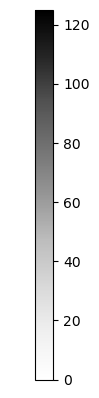

In [11]:
colormap: str = "Greys"

fig, ax = plt.subplots(1, 1)
fraction: int = 1
norm = mpl.colors.Normalize(vmin=0, vmax=maximum_weight)
cbar = ax.figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap),
                          ax=ax,
                          fraction=fraction)

ax.axis('off')
# Save the color bar for later use in figures.
plt.savefig('colorbar.svg', bbox_inches='tight')

<a id="section_ID_5.2"></a>
### 5.2 PyMOL Visualization

<div class="alert alert-block alert-info"> Use PyMOL to visualize the protein chains. If PyMOL is not available, the visualization with the generated PML-scripts will not work and you can skip 5.2 and go on with the next steps.</div>

First, open PyMOL and load a representation script.

In [12]:
if pymol_software:
    # Use PyMOL.
    os.system(f'{pymol} {folder_path}/show_best_modules_{weight_type}.pml')

 PyMOL(TM) Molecular Graphics System, Version 2.6.0a0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected OpenGL version 4.6. Shaders available.
 Geometry shaders not available
 Detected GLSL version 4.60.
 OpenGL graphics engine:
  GL_VENDOR:   Intel
  GL_RENDERER: Mesa Intel(R) HD Graphics 630 (KBL GT2)
  GL_VERSION:  4.6 (Compatibility Profile) 

 Executive: object "dist_H-6" created.
PyMOL>hide label, dist_H-6
PyMOL>dist dist_H-J, psH////PS1, psJ////PS1
 Executive: object "dist_H-J" created.
PyMOL>hide label, dist_H-J
PyMOL>dist dist_H-q, psH////PS1, psq////PS1
 Executive: object "dist_H-q" created.
PyMOL>hide label, dist_H-q
PyMOL>dist dist_H-9, psH////PS1, ps9////PS1
 Executive: object "dist_H-9" created.
PyMOL>hide label, dist_H-9
PyMOL>dist dist_H-d, psH////PS1, psd////PS1
 Executive: object "dist_H-d" created.
PyMOL>hide label, dist_H-d
PyMOL>dist dist_H-Y, psH////PS1, psY////PS1
 Executive: object "dist_H-Y" created.
PyMOL>hide label, dist_H-Y
PyMOL>dist dist_H-h, psH////PS1, psh////PS1
 Executive: object "dist_H-h" created.
PyMOL>hide label, dist_H-h
PyMOL>dist dist_H-z, psH////PS1, psz////PS1
 Executive: object "dist_H-z" created.
PyMOL>hide label, dist_H-z
PyMOL>dist dist_H-i, psH////PS1, psi////PS1
 Executive: object "dist_H-i" created.
PyMOL>hide label, dist_H-i
PyMOL>dist dist_H-m, psH////PS1, psm////PS1
 Executive

 Executive: object "dist_W-q" created.
PyMOL>hide label, dist_W-q
PyMOL>dist dist_W-r, psW////PS1, psr////PS1
 Executive: object "dist_W-r" created.
PyMOL>hide label, dist_W-r
PyMOL>dist dist_W-t, psW////PS1, pst////PS1
 Executive: object "dist_W-t" created.
PyMOL>hide label, dist_W-t
PyMOL>dist dist_W-w, psW////PS1, psw////PS1
 Executive: object "dist_W-w" created.
PyMOL>hide label, dist_W-w
PyMOL>dist dist_W-y, psW////PS1, psy////PS1
 Executive: object "dist_W-y" created.
PyMOL>hide label, dist_W-y
PyMOL>dist dist_X-L, psX////PS1, psL////PS1
 Executive: object "dist_X-L" created.
PyMOL>hide label, dist_X-L
PyMOL>dist dist_X-W, psX////PS1, psW////PS1
 Executive: object "dist_X-W" created.
PyMOL>hide label, dist_X-W
PyMOL>dist dist_X-r, psX////PS1, psr////PS1
 Executive: object "dist_X-r" created.
PyMOL>hide label, dist_X-r
PyMOL>dist dist_X-t, psX////PS1, pst////PS1
 Executive: object "dist_X-t" created.
PyMOL>hide label, dist_X-t
PyMOL>dist dist_X-u, psX////PS1, psu////PS1
 Executive

 Executive: object "dist_r-W" created.
PyMOL>hide label, dist_r-W
PyMOL>dist dist_r-X, psr////PS1, psX////PS1
 Executive: object "dist_r-X" created.
PyMOL>hide label, dist_r-X
PyMOL>dist dist_r-Z, psr////PS1, psZ////PS1
 Executive: object "dist_r-Z" created.
PyMOL>hide label, dist_r-Z
PyMOL>dist dist_r-s, psr////PS1, pss////PS1
 Executive: object "dist_r-s" created.
PyMOL>hide label, dist_r-s
PyMOL>dist dist_r-t, psr////PS1, pst////PS1
 Executive: object "dist_r-t" created.
PyMOL>hide label, dist_r-t
PyMOL>dist dist_s-L, pss////PS1, psL////PS1
 Executive: object "dist_s-L" created.
PyMOL>hide label, dist_s-L
PyMOL>dist dist_s-Z, pss////PS1, psZ////PS1
 Executive: object "dist_s-Z" created.
PyMOL>hide label, dist_s-Z
PyMOL>dist dist_s-r, pss////PS1, psr////PS1
 Executive: object "dist_s-r" created.
PyMOL>hide label, dist_s-r
PyMOL>dist dist_s-u, pss////PS1, psu////PS1
 Executive: object "dist_s-u" created.
PyMOL>hide label, dist_s-u
PyMOL>dist dist_s-v, pss////PS1, psv////PS1
 Executive

PyMOL>hide label, dist_4-6
PyMOL>dist dist_4-9, ps4////PS1, ps9////PS1
 Executive: object "dist_4-9" created.
PyMOL>hide label, dist_4-9
PyMOL>dist dist_4-b, ps4////PS1, psb////PS1
 Executive: object "dist_4-b" created.
PyMOL>hide label, dist_4-b
PyMOL>dist dist_4-c, ps4////PS1, psc////PS1
 Executive: object "dist_4-c" created.
PyMOL>hide label, dist_4-c
PyMOL>dist dist_4-f, ps4////PS1, psf////PS1
 Executive: object "dist_4-f" created.
PyMOL>hide label, dist_4-f
PyMOL>dist dist_4-g, ps4////PS1, psg////PS1
 Executive: object "dist_4-g" created.
PyMOL>hide label, dist_4-g
PyMOL>dist dist_4-h, ps4////PS1, psh////PS1
 Executive: object "dist_4-h" created.
PyMOL>hide label, dist_4-h
PyMOL>dist dist_5-3, ps5////PS1, ps3////PS1
 Executive: object "dist_5-3" created.
PyMOL>hide label, dist_5-3
PyMOL>dist dist_5-4, ps5////PS1, ps4////PS1
 Executive: object "dist_5-4" created.
PyMOL>hide label, dist_5-4
PyMOL>dist dist_5-6, ps5////PS1, ps6////PS1
 Executive: object "dist_5-6" created.
PyMOL>hide

 Executive: object "dist_h-5" created.
PyMOL>hide label, dist_h-5
PyMOL>dist dist_h-6, psh////PS1, ps6////PS1
 Executive: object "dist_h-6" created.
PyMOL>hide label, dist_h-6
PyMOL>dist dist_h-9, psh////PS1, ps9////PS1
 Executive: object "dist_h-9" created.
PyMOL>hide label, dist_h-9
PyMOL>dist dist_h-f, psh////PS1, psf////PS1
 Executive: object "dist_h-f" created.
PyMOL>hide label, dist_h-f
PyMOL>dist dist_h-i, psh////PS1, psi////PS1
 Executive: object "dist_h-i" created.
PyMOL>hide label, dist_h-i
PyMOL>dist dist_i-H, psi////PS1, psH////PS1
 Executive: object "dist_i-H" created.
PyMOL>hide label, dist_i-H
PyMOL>dist dist_i-3, psi////PS1, ps3////PS1
 Executive: object "dist_i-3" created.
PyMOL>hide label, dist_i-3
PyMOL>dist dist_i-6, psi////PS1, ps6////PS1
 Executive: object "dist_i-6" created.
PyMOL>hide label, dist_i-6
PyMOL>dist dist_i-9, psi////PS1, ps9////PS1
 Executive: object "dist_i-9" created.
PyMOL>hide label, dist_i-9
PyMOL>dist dist_i-b, psi////PS1, psb////PS1
 Executive

PyMOL>pseudoatom ps_A-m, psA or psm, label=7
 ObjMol: created ps_A-m/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_A-4, psA or ps4, label=23
 ObjMol: created ps_A-4/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_H-A, psH or psA, label=105
 ObjMol: created ps_H-A/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_H-6, psH or ps6, label=57
 ObjMol: created ps_H-6/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_H-J, psH or psJ, label=30
 ObjMol: created ps_H-J/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_H-q, psH or psq, label=37
 ObjMol: created ps_H-q/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_H-9, psH or ps9, label=24
 ObjMol: created ps_H-9/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_H-d, psH or psd, label=3
 ObjMol: created ps_H-d/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_H-Y, psH or psY, label=5
 ObjMol: created ps_H-Y/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_H-h, psH or psh, label=2
 ObjMol: created ps_H-h/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_H-z, psH or psz, label=45
 ObjMol: created ps_H-z/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_H-i, psH or psi

PyMOL>pseudoatom ps_Y-o, psY or pso, label=21
 ObjMol: created ps_Y-o/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_Y-q, psY or psq, label=67
 ObjMol: created ps_Y-q/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_Y-x, psY or psx, label=1
 ObjMol: created ps_Y-x/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_Y-z, psY or psz, label=39
 ObjMol: created ps_Y-z/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_Y-l, psY or psl, label=19
 ObjMol: created ps_Y-l/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_Y-m, psY or psm, label=41
 ObjMol: created ps_Y-m/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_Z-L, psZ or psL, label=32
 ObjMol: created ps_Z-L/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_Z-M, psZ or psM, label=23
 ObjMol: created ps_Z-M/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_Z-W, psZ or psW, label=43
 ObjMol: created ps_Z-W/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_Z-o, psZ or pso, label=30
 ObjMol: created ps_Z-o/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_Z-p, psZ or psp, label=14
 ObjMol: created ps_Z-p/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_Z-r, psZ or p

 ObjMol: created ps_w-L/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_w-M, psw or psM, label=52
 ObjMol: created ps_w-M/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_w-N, psw or psN, label=1
 ObjMol: created ps_w-N/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_w-W, psw or psW, label=31
 ObjMol: created ps_w-W/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_w-Z, psw or psZ, label=54
 ObjMol: created ps_w-Z/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_w-k, psw or psk, label=19
 ObjMol: created ps_w-k/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_w-o, psw or pso, label=4
 ObjMol: created ps_w-o/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_w-t, psw or pst, label=3
 ObjMol: created ps_w-t/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_w-4, psw or ps4, label=8
 ObjMol: created ps_w-4/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_x-Y, psx or psY, label=1
 ObjMol: created ps_x-Y/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_x-k, psx or psk, label=22
 ObjMol: created ps_x-k/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_x-o, psx or pso, label=29
 ObjMol: created ps_x-o/PSDO/P/PSD`1 

 ObjMol: created ps_b-d/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_b-i, psb or psi, label=24
 ObjMol: created ps_b-i/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_c-1, psc or ps1, label=18
 ObjMol: created ps_c-1/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_c-2, psc or ps2, label=4
 ObjMol: created ps_c-2/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_c-3, psc or ps3, label=54
 ObjMol: created ps_c-3/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_c-4, psc or ps4, label=1
 ObjMol: created ps_c-4/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_c-5, psc or ps5, label=40
 ObjMol: created ps_c-5/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_c-9, psc or ps9, label=6
 ObjMol: created ps_c-9/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_c-a, psc or psa, label=8
 ObjMol: created ps_c-a/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_c-b, psc or psb, label=4
 ObjMol: created ps_c-b/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_c-d, psc or psd, label=11
 ObjMol: created ps_c-d/PSDO/P/PSD`1 /PS1
PyMOL>pseudoatom ps_c-f, psc or psf, label=2
 ObjMol: created ps_c-f/PSDO/P/PSD`1 /

PyMOL>set_view (\
PyMOL>     0.231091082,    0.755019069,   -0.613631904,\
PyMOL>    -0.220976278,   -0.573489308,   -0.788846970,\
PyMOL>    -0.947507262,    0.317893296,    0.034313589,\
PyMOL>    -0.000325829,    0.000079326, -752.619812012,\
PyMOL>    96.238365173,   98.326240540,  148.597259521,\
PyMOL>   572.539062500,  932.690673828,  -20.000000000 )
 Scene: view updated.


Rotate the protein as desired in PyMOL and obtain the orientation by executing `get_view` from the PyMOL command line.  
To set the orientation as shown in the paper, insert the 'set_view' code block from section 5.3 into the PyMOL command line.
<br>
Example code block:
***
`set_view (\`  
     `  0.846083760,   -0.013588826,    0.532877386,\`  
     `  0.532879949,   -0.003809187,   -0.846183240,\`  
     `  0.013528440,    0.999899209,    0.004018756,\`  
     `  0.000000000,    0.000000000, -708.731262207,\`  
   `252.326522827,  202.360107422,  274.605560303,\`  
   `558.769104004,  858.693420410,  -20.000000000 )`
***

You can now write out the coordinates of the pseudoatoms to obtain the positions for the vertices in the graph representation. For that, insert the following code into the PyMOL shell as shown in below screenshots.

***
`xyz = cmd.get_coords("pseudoatoms", 1)`  
`python`  
`import numpy as np`  
`with open('pseudoatomCoords.npy', 'wb') as f: np.save(f, xyz)`  
`python end`

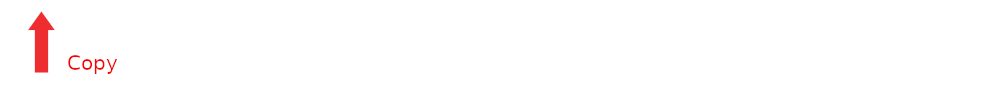

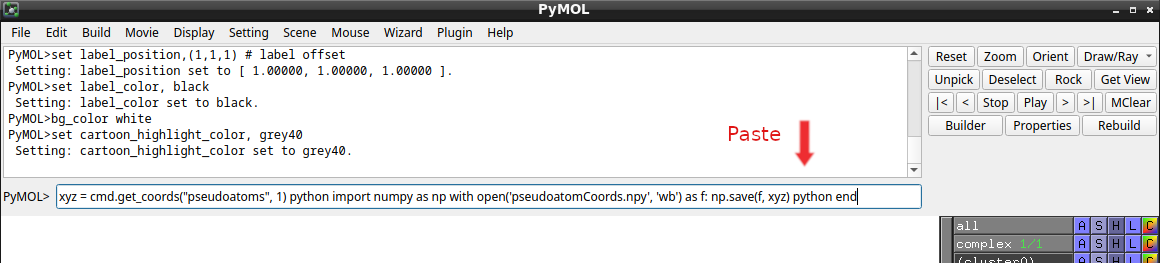

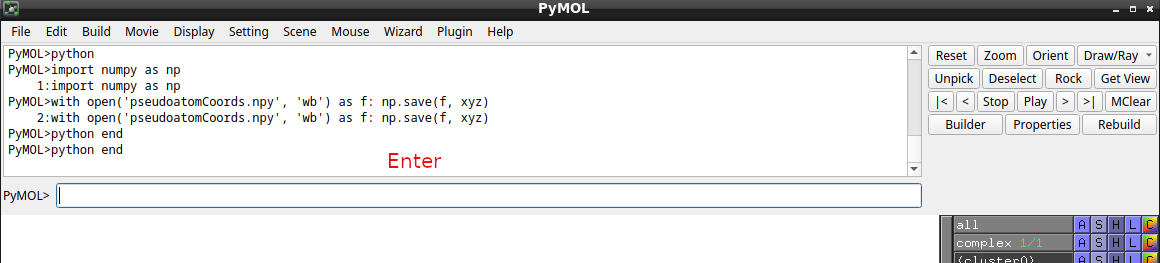

<div class="alert alert-block alert-info"> Note, that in order for the following cells (5.3 and further) to be executed, the cell running PyMOL first has to finish executing, i.e. quit PyMOL.</div>

<a id="section_ID_5.3"></a>
### 5.3 Prepare Layout According to the Pseudoatom Coordinates

The pseudoatom coordinates provide the geometric centers for each protein chain in the complex. The vertices in the graph figures are placed on the 2D projection of the pseudoatom coordinates along the z axis onto the xy plane. If the alpha values for the edge colors are used, the edges will be drawn accordingly, representing the depth in the plot view. For the vertices the alpha value is used in the respective colors and this might interfere with the alpha values for the depth view - change manually to not use the alpha values.

In [13]:
alpha = True

# Load the coordinates from file and create a numpy array.
coord_orig = np.load('pseudoatomCoords.npy')

# Use the provided set_view string to replicate the view from the results of the paper.
# It can be replaced with a different view from PyMOL, by replacing the string with the
# output of the 'get_view' statement as shown above.
set_view: str = 'set_view (\
     0.231091082,    0.755019069,   -0.613631904,\
    -0.220976278,   -0.573489308,   -0.788846970,\
    -0.947507262,    0.317893296,    0.034313589,\
    -0.000325829,    0.000079326, -752.619812012,\
    96.238365173,   98.326240540,  148.597259521,\
   572.539062500,  932.690673828,  -20.000000000 )'

if alpha:
    new_layout, alpha_values = createLayout(set_view, coord_orig, alpha=True)
else:
    new_layout = createLayout(set_view, coord_orig, alpha=False)

<a id="section_ID_5.4"></a>
### 5.4 Prepare a General Representation Style for the Graphs

<a id="section_ID_5.4.1"></a>
#### 5.4.1 Prepare a Dictionary for Vertex Names for Complex I

For complex I, the human gene names are commonly used. The dictionary in the cell below maps the chain names to the gene names according to the format shown in the table.<br>
For the reference memberships the biological assumption for the modules of complex I
according to Guerrero-Castillo S et al. (2017) Cell Metab.25:128-139 has been used. The modules in ref2 are identical to ref 1 but with further subdivision.

|Chain|Gene Name|Short Gene Name|Biological Modules (ref1)|Biological Modules (ref2)|
|----:|--------:|:-------------:|:-------------:|:-------------:|
|F   |NDUFA2    |A2             |P_P            |P_P-b          |
|M   |NDUFS1    |S1             |P_P            |P_P-a          |
|... |...       |...            |...            |...            |

In [14]:
gene_names_dict: dict = {
    'A': ['MT-ND3', 'ND3'  , 'P_P', 'P_P-b'],
    'H': ['MT-ND1', 'ND1'  , 'P_P', 'P_P-a'],
    'J': ['MT-ND6', 'ND6'  , 'P_P', 'P_P-b'],
    'K': ['MT-ND4L', 'ND4L', 'P_P', 'P_P-b'],
    'L': ['MT-ND5', 'ND5'  , 'P_D', 'P_D-b'],
    'M': ['MT-ND4', 'ND4'  , 'P_D', 'P_D-a'],
    'N': ['MT-ND2', 'ND2'  , 'P_P', 'P_P-b'],
    'V': ['NDUFC1', 'C1'   , 'P_P', 'P_P-b'],
    'W': ['NDUFB1', 'B1'   , 'P_D', 'P_D-a'],
    'X': ['NDUFAB1', 'AB1' , 'P_D', 'P_D-b'],
    'Y': ['NDUFA8', 'A8'   , 'P_P', 'P_P-a'],
    'Z': ['NDUFB10', 'B10' , 'P_D', 'P_D-a'],
    'k': ['NDUFA10', 'A10' , 'P_P', 'P_P-b'],
    'l': ['NDUFS5', 'S5'   , 'P_P', 'P_P-b'],
    'm': ['NDUFA3', 'A3'   , 'P_P', 'P_P-a'],
    'n': ['NDUFB3', 'B3'   , 'P_D', 'P_D-b'],
    'o': ['NDUFC2', 'C2'   , 'P_P', 'P_P-b'],
    'p': ['NDUFB4', 'B4'   , 'P_D', 'P_D-a'],
    'q': ['NDUFA13', 'A13' , 'P_P', 'P_P-a'],
    'r': ['NDUFB6', 'B6'   , 'P_D', 'P_D-a'],
    's': ['NDUFB7', 'B7'   , 'P_D', 'P_D-b'],
    't': ['NDUFB9', 'B9'   , 'P_D', 'P_D-b'],
    'u': ['NDUFB2', 'B2'   , 'P_D', 'P_D-b'],
    'v': ['NDUFB8', 'B8'   , 'P_D', 'P_D-b'],
    'w': ['NDUFB11', 'B11' , 'P_D', 'P_D-a'],
    'x': ['NDUFA11', 'A11' , 'P_P', 'P_P-b'],
    'y': ['NDUFB5', 'B5'   , 'P_D', 'P_D-a'],
    'z': ['NDUFA1', 'A1'   , 'P_P', 'P_P-a'],
    '1': ['NDUFV1', 'V1'   , 'N', 'N'],
    '2': ['NDUFV2', 'V2'   , 'N', 'N'],
    '3': ['NDUFS1', 'S1'   , 'N', 'N'],
    '4': ['NDUFS2', 'S2'   , 'Q', 'Q'],
    '5': ['NDUFS3', 'S3'   , 'Q', 'Q'],
    '6': ['NDUFS7', 'S7'   , 'Q', 'Q'],
    '9': ['NDUFS8', 'S8'   , 'Q', 'Q'],
    'a': ['NDUFV3', 'V3'   , 'N', 'N'],
    'b': ['NDUFS6', 'S6'   , 'N', 'N'],
    'c': ['NDUFS4', 'S4'   , 'N', 'N'],
    'd': ['NDUFA9', 'A9'   , 'Q', 'Q'],
    'e': ['NDUFA2', 'A2'   , 'N', 'N'],
    'f': ['NDUFA5', 'A5'   , 'Q', 'Q'],
    'g': ['NDUFA6', 'A6'   , 'Q', 'Q'],
    'h': ['NDUFA7', 'A7'   , 'Q', 'Q'],
    'i': ['NDUFA12', 'A12' , 'N', 'N'],
    'j': ['NDUFAB1', 'AB1' , 'Q', 'Q'],
}

<a id="section_ID_5.4.2"></a>
#### 5.4.2 Optional Modification of Vertex Positions

Vertex positions might overlap in the adjusted view. Slight modifications for a better representation can be applied. For easier insight how to modify vertex positions, a dictionary is created which stores the coordinates and the respective chain names.

In [15]:
vertex_positions: dict = {}
for number, name in enumerate(G.vs['label']):
    vertex_positions[name] = new_layout[number]
print(vertex_positions)

# If necessary (e.g. because of overlapping vertices) modify the positions of the vertices.
#new_layout: list = modifyLayoutPosition('9', new_layout, G, [-211.49, 80.562])
#new_layout: list = modifyLayoutPosition('V', new_layout, G, [-124.806, 140.532])

{'A': [-174.272, 125.954], 'H': [-189.101, 126.789], 'J': [-167.682, 136.651], 'K': [-158.695, 134.02], 'L': [-61.487, 135.655], 'M': [-92.836, 142.435], 'N': [-132.429, 138.677], 'V': [-128.3, 138.111], 'W': [-96.191, 161.932], 'X': [-51.553, 90.972], 'Y': [-181.948, 174.895], 'Z': [-71.179, 172.915], 'k': [-127.305, 105.513], 'l': [-165.209, 163.189], 'm': [-178.632, 159.651], 'n': [-31.048, 108.76], 'o': [-120.614, 162.347], 'p': [-87.843, 119.109], 'q': [-186.761, 149.639], 'r': [-51.162, 140.355], 's': [-44.682, 159.407], 't': [-65.195, 98.208], 'u': [-32.012, 135.028], 'v': [-76.331, 123.855], 'w': [-83.024, 151.844], 'x': [-122.965, 154.373], 'y': [-94.653, 170.01], 'z': [-201.649, 148.369], '1': [-215.382, 18.179], '2': [-230.774, 15.179], '3': [-192.86, 30.336], '4': [-182.186, 88.709], '5': [-172.495, 69.639], '6': [-199.367, 94.669], '9': [-205.544, 83.362], 'a': [-222.782, 0.0], 'b': [-221.927, 57.162], 'c': [-180.753, 47.094], 'd': [-188.639, 86.974], 'e': [-163.105, 21.26

<a id="section_ID_5.4.3"></a>
#### 5.4.3 Prepare a General Graph Layout Style

The edge labels for the graphs below are switched off by default for better clarity.

In [16]:
defined_width: list = [x/10 for x in G.es[weight_type]]
labeled_vertices: list = [gene_names_dict[name][1] for name in G.vs['label']]

visual_style: dict = {
    'layout': new_layout,
    'bbox': (600, 600),
    'margin': 30,
    'edge_width': defined_width,
    'edge_label': None,  # To switch off labeling of the edges.
    'vertex_shape': 'circle',
    'vertex_label': labeled_vertices,
    'vertex_label_color': 'black',
    'vertex_label_size': 11
}

<a id="section_ID_5.5"></a>
### 5.5 Graph Visualization with Focus on the Network

<a id="section_ID_5.5.1"></a>
#### 5.5.1 Layout Style with Focus on Network

In the cell below the edge weight colors and the alpha values are applied.
The visual style for this graph is created with a focus on the network and its edges, meaning no colored clusters.

The alpha value for the network-focused style is recommended to be set to False to see the real colors according to the edge weights.

In [17]:
alpha: bool = False
cmap = plt.get_cmap(colormap)

# General Network Layout:
visual_style_network: dict = visual_style.copy()
visual_style_network["vertex_size"]: int = 8
visual_style_network["vertex_label"]: list = None
visual_style_network["vertex_color"]: list = [ig.color_name_to_rgba('gray95')
                                              for vertex in G.vs()]
visual_style_network["vertex_frame_width"]: int = 4
# First create the list and if required apply the modification for the alpha values.
visual_style_network["vertex_frame_color"]: list = [ig.color_name_to_rgba('darkgreen')
                                                    for vertex in G.vs()]

# With alpha value.
if alpha:
    visual_style_network["edge_color"]: list = \
                            [cmap(edge[weight_type]/maximum_weight)[:-1]
                             + ((alpha_values[edge.source] + alpha_values[edge.target])/2,)
                             for edge in G.es()]
    visual_style_network["vertex_frame_color"]: list = \
                            [visual_style_network["vertex_frame_color"][number][:-1]
                            + (alpha_values[int(vertex['id'])],)
                            for number, vertex in enumerate(G.vs())]
    visual_style_network["vertex_color"]: list = \
                            [visual_style_network["vertex_color"][number][:-1]
                            + (alpha_values[int(vertex['id'])],)
                            for number, vertex in enumerate(G.vs())]
# Without alpha value.
else:  
    visual_style_network["edge_color"] = \
                            [cmap(weight/maximum_weight)
                             for weight in G.es[weight_type]]

<a id="section_ID_5.5.2"></a>
#### 5.5.2 Plotting the Graph

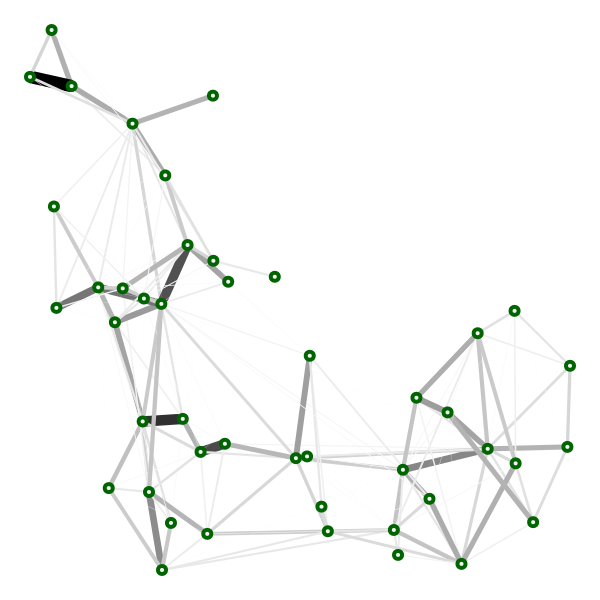

In [18]:
# This plot also gets saved as a file to the current working directory.
file_name_netrep: str = f'networkRepresentation_{weight_type}.svg'
ig.plot(G, file_name_netrep, **visual_style_network)

<a id="section_ID_5.6"></a>
### 5.6 Graph Visualization with Focus on the Computed Partitions

<a id="section_ID_5.6.1"></a>
#### 5.6.1 Layout Style with Labels and Partitions

In the cell below the visual style for the graph is created with focus on the computed partitions, meaning it shows labels of the vertices and the partitioning.

The alpha value can be set to true for depth perception.

In [19]:
# Adjust the colors according to a uniform representation in the publication.
frameColorList: list = []
for membership in partitions[weight_type].membership:
    frameColorList.append((colorList[membership][0], colorList[membership][1], colorList[membership][2], 1.0))

In [20]:
alpha = True

# General Cluster Layout:
visual_style_cluster: dict = visual_style.copy()
visual_style_cluster["vertex_size"]: int = 32
visual_style_cluster["vertex_color"]: list = [ig.color_name_to_rgba('white')
                                              for vertex in G.vs()]
visual_style_cluster["vertex_frame_width"]: int = 5
# First create the list and if required apply the modification for the alpha values.
#visual_style_cluster["vertex_frame_color"]: list = \
#                    ig.drawing.colors.ClusterColoringPalette(len(partitions[weight_type]))\
#                    .get_many(partitions[weight_type].membership)
# The vertex_frame_color key is hard-coded to be consistent with the paper.
visual_style_cluster["vertex_frame_color"] = frameColorList

# With alpha value.
if alpha:
    visual_style_cluster["edge_color"]: list = \
                            [cmap(edge[weight_type]/maximum_weight)[:-1]
                             + ((alpha_values[edge.source] + alpha_values[edge.target])/2,)
                             for edge in G.es()]
    visual_style_cluster["vertex_frame_color"]: list = \
                            [visual_style_cluster["vertex_frame_color"][number][:-1]
                             + (alpha_values[int(vertex['id'])],)
                             for number, vertex in enumerate(G.vs())]
    visual_style_cluster["vertex_color"]: list = \
                            [visual_style_cluster["vertex_color"][number][:-1]
                             + (alpha_values[int(vertex['id'])],)
                             for number, vertex in enumerate(G.vs())]
# Without alpha value.
else:
    visual_style_cluster["edge_color"]: list = \
                            [cmap(weight/maximum_weight)
                             for weight in G.es[weight_type]]


<a id="section_ID_5.6.2"></a>
#### 5.6.2 Plotting the Graph

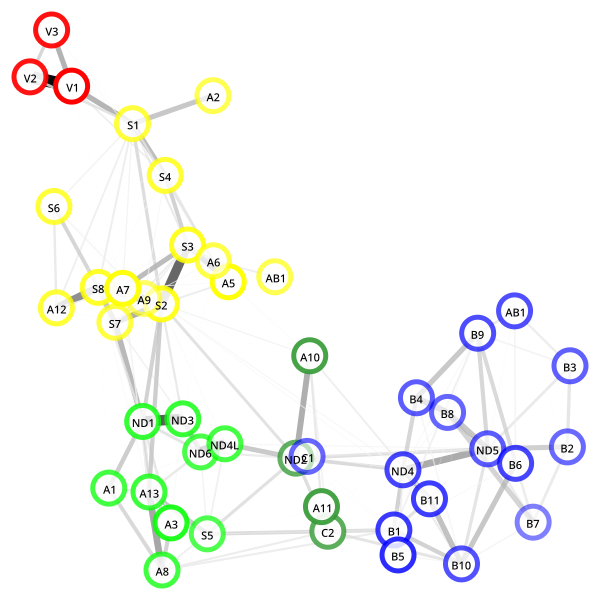

In [21]:
# This plot gets saved as a file to the current working directory.
file_name_clrep: str = f'clusterRepresentation_{weight_type}.svg'
ig.plot(partitions[weight_type], file_name_clrep, **visual_style_cluster)


<a id="section_ID_6"></a>
## 6. Graph Analysis Metrics

<a id="section_ID_6.1"></a>
### 6.1 Community Comparison

<a id="section_ID_6.1.1"></a>
#### 6.1.1 Calculated Memberships and Reference Memberships

In [22]:
# Extracting the membership vector of the previously calculated communities via the Leiden algorithm.
calculated_memberships = best_partition.membership
print("Calculated Memberships: ", calculated_memberships)

print("Best Partition: ", best_partition)


# For the reference memberships the biological assumption for the modules of complex I
# according to Guerrero-Castillo S et al. (2017) Cell Metab.25:128-139 has been used.

# ref_memberships_wo_subdiv - N := 0; Q:= 1; P_P:= 2; P_D:= 3
# ref_memberships_w_subdiv - N := 0; Q:= 1; P_P-a:= 2; P_P-b:= 3; P_D-a:= 4; P_D-b:= 5

ref_memberships_wo_subdiv = []
ref_memberships_w_subdiv = []
for item in gene_names_dict.keys():
    if gene_names_dict[item][2] == 'N':
        ref_memberships_wo_subdiv.append(0)
    elif gene_names_dict[item][2] == 'Q':
        ref_memberships_wo_subdiv.append(1)
    elif gene_names_dict[item][2] == 'P_P':
        ref_memberships_wo_subdiv.append(2)
    elif gene_names_dict[item][2] == 'P_D':
        ref_memberships_wo_subdiv.append(3)
    
    if gene_names_dict[item][3] == 'N':
        ref_memberships_w_subdiv.append(0)
    elif gene_names_dict[item][3] == 'Q':
        ref_memberships_w_subdiv.append(1)
    elif gene_names_dict[item][3] == 'P_P-a':
        ref_memberships_w_subdiv.append(2)
    elif gene_names_dict[item][3] == 'P_P-b':
        ref_memberships_w_subdiv.append(3)
    elif gene_names_dict[item][3] == 'P_D-a':
        ref_memberships_w_subdiv.append(4)
    elif gene_names_dict[item][3] == 'P_D-b':
        ref_memberships_w_subdiv.append(5)

# The reference biological memberships without subdivision:
print(f"Reference without subdivision membership vector: {ref_memberships_wo_subdiv}")
# The reference biological memberships with subdivision:
print(f"Reference with subdivision membership vector: {ref_memberships_w_subdiv}")


Calculated Memberships:  [0, 0, 0, 0, 2, 2, 3, 2, 2, 2, 0, 2, 3, 0, 0, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 3, 2, 0, 4, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best Partition:  Clustering with 45 elements and 5 clusters
[0] 0, 1, 2, 3, 10, 13, 14, 18, 27
[1] 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44
[2] 4, 5, 7, 8, 9, 11, 15, 17, 19, 20, 21, 22, 23, 24, 26
[3] 6, 12, 16, 25
[4] 28, 29, 35
Reference without subdivision membership vector: [2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]
Reference with subdivision membership vector: [3, 2, 3, 3, 5, 4, 3, 3, 4, 5, 2, 4, 3, 3, 2, 5, 3, 4, 2, 4, 5, 5, 5, 5, 4, 3, 4, 2, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]


<a id="section_ID_6.1.2"></a>
#### 6.1.2 Rand Index

In [23]:
# Calculating the Rand index.
rand_index_wo_subdiv = ig.compare_communities(ref_memberships_wo_subdiv,
                                              calculated_memberships,
                                              method='rand')
rand_index_w_subdiv = ig.compare_communities(ref_memberships_w_subdiv,
                                             calculated_memberships,
                                             method='rand')

print()
print("Rand index without subdivision: ", rand_index_wo_subdiv)
print("Rand index with subdivision: ", rand_index_w_subdiv)


Rand index without subdivision:  0.8757575757575758
Rand index with subdivision:  0.8313131313131311


<a id="section_ID_6.1.3"></a>
#### 6.1.3 Adjusted Rand Index

In [24]:
# Calculating the adjusted Rand index.
adjusted_rand_index_wo_subdiv = ig.compare_communities(ref_memberships_wo_subdiv,
                                                       calculated_memberships,
                                                       method='adjusted_rand')
adjusted_rand_index_w_subdiv = ig.compare_communities(ref_memberships_w_subdiv,
                                                      calculated_memberships,
                                                      method='adjusted_rand')

print("Adjusted Rand index without subdivision: ", adjusted_rand_index_wo_subdiv)
print("Adjusted Rand index with subdivision: ", adjusted_rand_index_w_subdiv)


Adjusted Rand index without subdivision:  0.6650603204990678
Adjusted Rand index with subdivision:  0.47648239742120113


<a id="section_ID_6.2"></a>
### 6.2 Strength

In [25]:
vertexStrength = G.strength(G.vs, mode='all', loops=False, weights=weight_type)

In [26]:
for value in range(len(vertexStrength)):
    print(f'{labeled_vertices[value]}  {vertexStrength[value]}')

ND3  226.0
ND1  377.0
ND6  257.0
ND4L  191.0
ND5  444.0
ND4  336.0
ND2  332.0
C1  48.0
B1  269.0
AB1  80.0
A8  227.0
B10  278.0
A10  140.0
S5  183.0
A3  103.0
B3  101.0
C2  168.0
B4  199.0
A13  288.0
B6  174.0
B7  147.0
B9  218.0
B2  118.0
B8  190.0
B11  173.0
A11  52.0
B5  54.0
A1  119.0
V1  253.0
V2  192.0
S1  340.0
S2  514.0
S3  342.0
S7  233.0
S8  359.0
V3  100.0
S6  105.0
S4  177.0
A9  97.0
A2  51.0
A5  92.0
A6  120.0
A7  182.0
A12  148.0
AB1  21.0


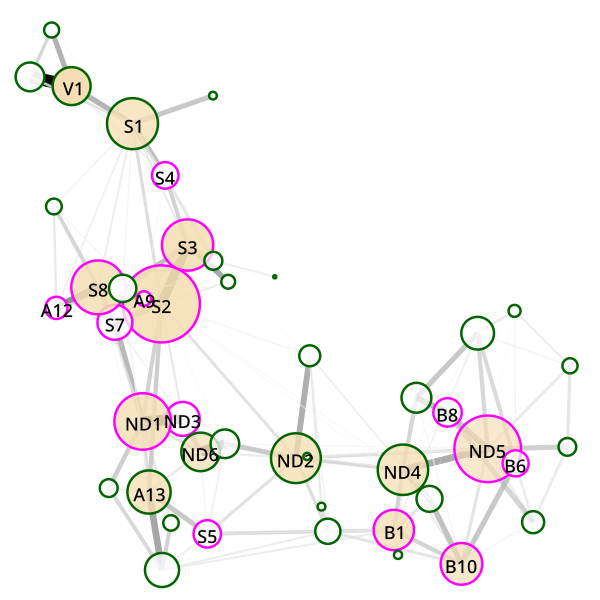

In [27]:
file_name_strength: str = f'strength_{weight_type}.svg'
    
visual_style_strength: dict = visual_style_cluster.copy()

largeChanges: list = ["c","i","4","5","6","9","d","H","l","A","r","W","Z","v","L"]
highStrength: list = ["1","3","4","5","9","q","H","J","N","W","M","Z","L"]  

visual_style_strength["vertex_size"] = [x*0.15 for x in vertexStrength]
visual_style_strength["vertex_label"] = [labeled_vertices[x] 
                                       if (v["label"] in largeChanges or v["label"] in highStrength)
                                       else ' ' 
                                       for x,v in enumerate(G.vs)]
visual_style_strength["vertex_label_size"]: int = 18
visual_style_strength["vertex_frame_width"]: int = 2.5
visual_style_strength["vertex_color"]: list = [ig.color_name_to_rgba('wheat') 
                                               if vertex["label"] in highStrength 
                                               else ig.color_name_to_rgba('white')
                                               for vertex in G.vs()]
visual_style_strength["vertex_color"]: list = \
                            [visual_style_strength["vertex_color"][number][:-1]
                             + (alpha_values[int(vertex['id'])],)
                             for number, vertex in enumerate(G.vs())]
#visual_style_strength["vertex_frame_color"]: list = [ig.color_name_to_rgba('darkgreen')
#                                                    for vertex in G.vs()]
visual_style_strength["vertex_frame_color"]: list = [ig.color_name_to_rgba('magenta')
                                                   if v["label"] in largeChanges
                                                   else ig.color_name_to_rgba('darkgreen') 
                                                   for v in G.vs]
ig.plot(partitions[weight_type], file_name_strength, **visual_style_strength)

<a id="section_ID_6.3"></a>
### 6.3 Eigenvector Centrality

In [28]:
results_eigenvectorCentrality = G.eigenvector_centrality(directed=False, scale=True, weights=weight_type, return_eigenvalue=False)

In [29]:
for value in range(len(results_eigenvectorCentrality)):
    print(f'{labeled_vertices[value]}  {results_eigenvectorCentrality[value]:.2f}')

ND3  0.49
ND1  0.70
ND6  0.36
ND4L  0.26
ND5  0.25
ND4  0.26
ND2  0.35
C1  0.05
B1  0.17
AB1  0.03
A8  0.24
B10  0.15
A10  0.15
S5  0.21
A3  0.17
B3  0.04
C2  0.12
B4  0.12
A13  0.47
B6  0.09
B7  0.07
B9  0.11
B2  0.06
B8  0.11
B11  0.15
A11  0.03
B5  0.04
A1  0.21
V1  0.19
V2  0.14
S1  0.41
S2  1.00
S3  0.65
S7  0.61
S8  0.71
V3  0.07
S6  0.19
S4  0.25
A9  0.16
A2  0.08
A5  0.22
A6  0.17
A7  0.44
A12  0.30
AB1  0.01


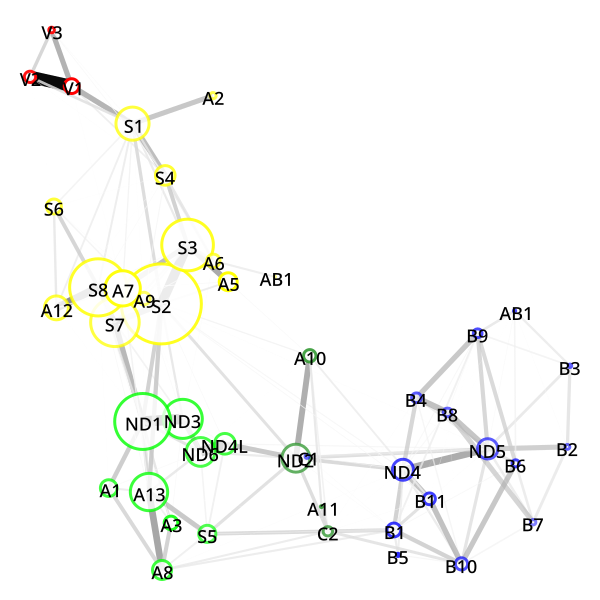

In [30]:
file_name_eigenvector: str = f'eigenvectorCentrality_{weight_type}.svg'

visual_style_eigenvector: dict = visual_style_cluster.copy()
    
visual_style_eigenvector["vertex_frame_width"]: int = 3
visual_style_eigenvector["vertex_label_size"]: int = 18
visual_style_eigenvector["vertex_size"] = [x*80 for x in results_eigenvectorCentrality]
ig.plot(partitions[weight_type], file_name_eigenvector, **visual_style_eigenvector)


<a id="section_ID_6.4"></a>
### 6.4 Betweenness Centrality

In [31]:
results_betweenness = G.betweenness(vertices=None, directed=False, cutoff=None, weights=weight_type)

In [32]:
for value in range(len(results_betweenness)):
    print(f'{labeled_vertices[value]}  {results_betweenness[value]:.2f}')

ND3  87.33
ND1  142.00
ND6  367.00
ND4L  0.00
ND5  217.50
ND4  44.00
ND2  70.83
C1  0.00
B1  298.67
AB1  186.50
A8  51.00
B10  80.00
A10  60.83
S5  40.00
A3  292.17
B3  0.00
C2  42.00
B4  0.00
A13  45.00
B6  0.00
B7  0.00
B9  37.50
B2  0.00
B8  115.00
B11  167.83
A11  0.00
B5  0.00
A1  6.00
V1  0.00
V2  0.00
S1  68.50
S2  133.00
S3  0.00
S7  0.00
S8  62.00
V3  0.00
S6  0.00
S4  153.50
A9  262.50
A2  0.00
A5  2.67
A6  43.00
A7  81.00
A12  60.00
AB1  0.00


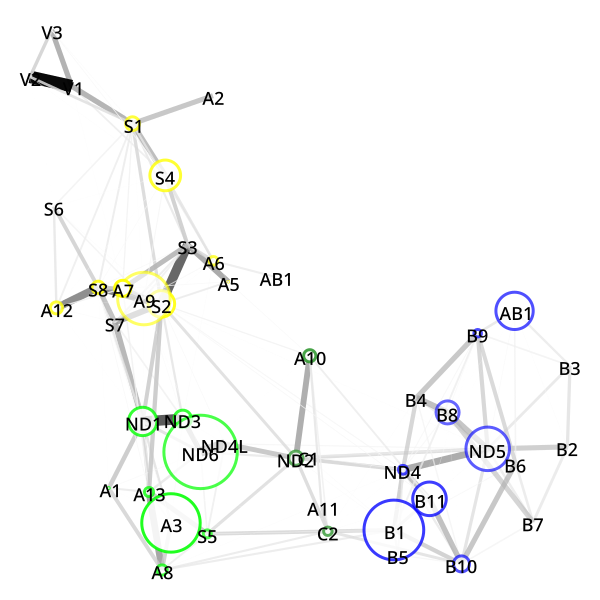

In [33]:
file_name_betweenness: str = f'betweenness_{weight_type}.svg'

visual_style_betweenness: dict = visual_style_cluster.copy()

visual_style_betweenness["vertex_frame_width"]: int = 3
visual_style_betweenness["vertex_label_size"]: int = 18
visual_style_betweenness["vertex_size"] = [x*0.2 for x in results_betweenness]
ig.plot(partitions[weight_type], file_name_betweenness, **visual_style_betweenness)